# 全卷积神经网络 FCN

- 使用转置卷积替换CNN最后的全连接层，去掉了全局池化层
    - 添加 1x1 Conv
    - 添加转置卷积层，放大图片
    - 输出使用通道表示对类的识别

In [15]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from PIL import Image
from d2l import torch as d2l

In [16]:
pretrain_net = torchvision.models.resnet34(pretrained=True)
list(pretrain_net.children())[-2:] # 最后两层是全局池化+全连接

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [17]:
net = nn.Sequential(*list(pretrain_net.children())[:-2])

X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [18]:
num_classes = 21 # VOC2012 一共存在21类
net.add_module(
    '1x1 Conv',
    # 取 num_classes 便于计算
    nn.Conv2d(512, 256, kernel_size=1)
)

net.add_module(
    'transpose_conv',
    # 放大 32 倍 > stride = 32
    # kernel_size = 64 每一次只跳32，让窗口间存在一半的重叠度
    # n = 320 == (32 * 10 + 64 - 2 * p - 32)
    nn.ConvTranspose2d(
        256, num_classes,
        kernel_size=64, padding=16,
        stride=32
    )
)

In [19]:
# 卷积层初始化 高宽双线性插值 中心是1 周围是0
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1), 
          torch.arange(kernel_size).reshape(1, -1))
    # 到中心的距离 / 半边长
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros(
        in_channels, out_channels, kernel_size, kernel_size
    )
    for i in range(in_channels):
        for j in range(out_channels):
            if (i == j):
                weight[i, j, :, :] = filt
    return weight

In [20]:
bilinear_kernel(1, 1, 3)

tensor([[[[0.2500, 0.5000, 0.2500],
          [0.5000, 1.0000, 0.5000],
          [0.2500, 0.5000, 0.2500]]]])

torch.Size([3, 561, 728])
torch.Size([1122, 1456, 3])


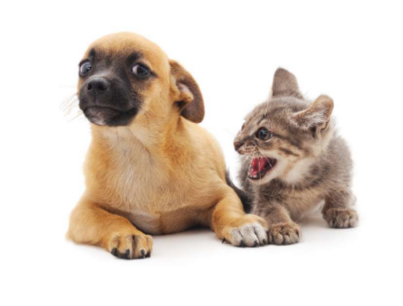

In [21]:
conv_trans = nn.ConvTranspose2d(
    in_channels=3, out_channels=3, kernel_size=4, padding=1, stride=2, bias=False
) # 高宽翻倍

# 使用双线性插值初始化
conv_trans.weight.data.copy_(
    bilinear_kernel(
        in_channels=3, out_channels=3, kernel_size=4
    )
)

img = torchvision.transforms.ToTensor() (
    Image.open(
        os.path.join('.', 'img', 'catdog.jpg')
    )
)

print(img.shape)
X = img.unsqueeze(dim=0)
Y = conv_trans(X)
backend_inline.set_matplotlib_formats('svg')
out_img = Y[0].permute(1, 2, 0).detach()
print(out_img.shape)

plt.rcParams['figure.figsize'] = (7, 5)
plt.imshow(out_img)
plt.axis('off')
plt.show()

**对于转置卷积层使用双线性插值，对普通的卷积层使用 Xavier**

In [22]:
net.transpose_conv.weight.data.copy_(
    bilinear_kernel(256, num_classes, 64) + 
    torch.normal(mean=0, std=0.01, size=(256, num_classes, 64, 64))
); # 使用 ; 防止jupyter输出

In [23]:
batch_size, crop_size = 10, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size=batch_size, crop_size=crop_size)

read 1114 examples
read 1078 examples


loss 0.178, train acc 0.938, test acc 0.877
42.1 examples/sec on [device(type='cuda', index=0)]


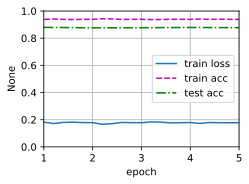

In [26]:
# loss 的计算不同，现在的损失函数的输入是矩阵，所以需要做均值
def loss(inputs, targets):
    return F.cross_entropy(
        input=inputs, target=targets, reduction='none'
    ).mean(dim=1).mean(dim=1)

num_epochs, lr, weight_decay, device = 5, 1e-7, 0, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr, weight_decay)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, device)

In [27]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(device[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

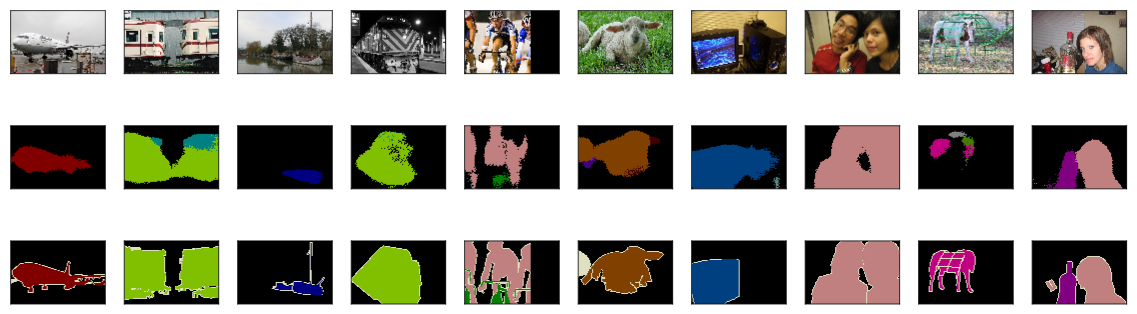

In [28]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=device[0])
    X = pred.long()
    return colormap[X, :]

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 10, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0).type(torch.uint8),
        pred.cpu().type(torch.uint8),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0).type(torch.uint8)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);
plt.rcParams['figure.figsize'] = (7, 5)

# QA

- Unet 将 Conv 的每一层都做了层层的 TConv 精度更好

In [ ]:
torch.cuda.empty_cache()